# Question 1

Suppose $X_1, X_2, \cdots, X_n \sim F$ (i.i.d. draws) and $Y_1, Y_2, \cdots, Y_n$ is a Markov Chain with $F$ as the stationary distribution. Consider two estimates of the mean:
$$
\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i \\
\bar{Y} = \frac{1}{n}\sum_{i=1}^n Y_i
$$
Which estimator is better? Support with formal mathematical arguments.

## Solution

The estimator $\bar{X}$ is better because it's the sample mean of $X$ that is sampled directly from $F$, while the samples $Y$ have been estimated to be sampled from the distribution $F$ through Markov Chains. We may assume that $Y$ is sampled from $F$ after a burnout threshold, but it's always nearly sampled.  
This leads to $\bar{Y}$ being the sample mean of samples from a distribution that simulates $F$ but isn't, while $X$ is exactly from $F$.

# Question 2

Suppose $Y_1, Y_2, \cdots, Y_n \hspace{4pt}\vert \hspace{4pt} \mu \sim N(\mu, 1)$.  Assume the prior on $\mu \sim t_\nu$, where $\nu$ is the degrees of freedom. Assume the prior on $\nu \sim \textit{Truncated Gamma}(a_0, b_0, (2, \infty))$, where $(2, \infty)$ is the support of the same.
- What is the joint posterior distribution of $(\mu, \nu)$
- Write an Metropolis-Hastings algorithm to sample from the above posterior distribution.
- Generate n = 100 data points. Set $a_0 = 2, b_0 = 0.1$, and run the MH algorithm mentioned above

## Solution

Posterior belief $\propto$ Evidence * Prior belief $\implies P(\lambda \vert Y) = \frac{P(Y \vert \lambda) P(\lambda)}{P(Y)}$.  
This is equivalent to if $\lambda = (\mu, \nu)$ then $P(\lambda \vert Y) \propto P(Y \vert \mu) P(\mu) = P(Y \vert \mu) P(\mu \vert \nu) P(\nu)$  
$\implies N(\mu, 1) * t(\nu) * \textit{Truncated Gamma}(a_0, b_0, (2, \infty))$

In [372]:
using Statistics
using Distributions
using Random
Random.seed!(13);

In [373]:
a₀, b₀ = 2, 0.1;
n = 100;

In [374]:
function posterior_pdf(x, λ)
    #=
    Returns the posterior pdf value at x, upto a proportionality constant
    λ := [μ, ν]
    =#
    μ = λ[1]
    ν = λ[2]
    g = ν^(a₀-1)*exp(-ν/b₀)
    t = (1 + μ^2/ν)^(-(ν+1)/2)
    p = exp(-(x-μ)^2/2)
    i = x ≥ 2 ? 1 : 0
    return p*t*(g*i)
end

posterior_pdf (generic function with 1 method)

In [375]:
function proposal_pdf(x_new, x_curr)
    #=
    Returns the proposal pdf value at x, upto a proportionality constant
    =#
    return exp(-(x_new-x_curr)^2/2)
end

proposal_pdf (generic function with 1 method)

In [376]:
function metropolis_hastings(n, x_curr, λ)
    n = 2*n; # will dump off first n values later
    samples_x = zeros(n)
    samples_λ = zeros(n, 2)
    idx = 1
    λ_new = zeros(2)
    while idx ≤ n
        # store
        samples_x[idx] = x_curr
        samples_λ[idx, :] = λ
        idx += 1

        # Proposal distribution:
        proposal_dist = Normal(x_curr, 1)
        x_new = rand(proposal_dist, 1)[1]

        # Updating params
        student_dist = TDist(λ[2]);
        λ_new[1] = rand(student_dist, 1)[1]
        gamma_dist = truncated(Gamma(a₀, b₀), lower=2);
        λ_new[2] = rand(gamma_dist, 1)[1]

        # checking if x_new would give higher posterior belief, or x_curr would
        ratio_posterior = posterior_pdf(x_new, λ)/posterior_pdf(x_curr, λ)
        ratio_proposal = proposal_pdf(x_curr, x_new)/proposal_pdf(x_new, x_curr)
        α = min(1, ratio_posterior*ratio_proposal)

        # updating x_curr with probability of α
        u = rand(Uniform(), 1)[1]
        if u < α
            x_curr = x_new
            λ = λ_new
        end
    end
    # returning later 50% of samples
    return samples_x[Int(n/2)+1:end], samples_λ[Int(n/2)+1:end, :], λ
end

metropolis_hastings (generic function with 3 methods)

In [377]:
x_start, λ = 1, [1, 1];
data_x, data_λ, λ = metropolis_hastings(n, x_start, λ);
println("Last values of μ and ν: ", λ)

Last values of μ and ν: [-0.5271958033575241, 2.0806041097438395]


Mean: 2.50495431405406
Variance: 0.25221364069717617


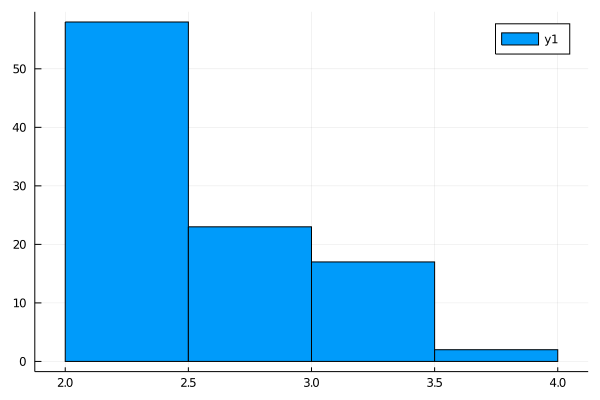

In [378]:
println("Mean: ", mean(data_x))
println("Variance: ", var(data_x))
histogram(data_x)
# data_x

Mean of μ: 0.02932938051042807
Variance of μ: 2.1989094786316556


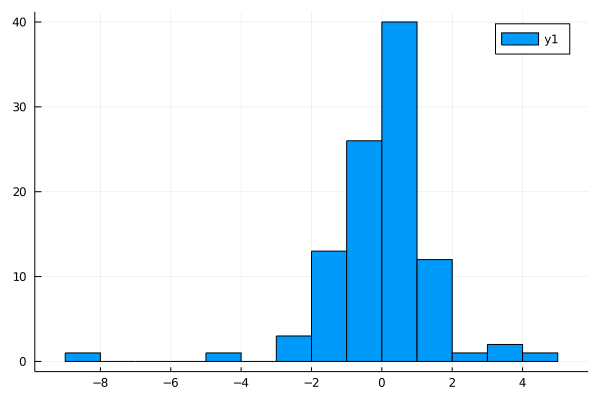

In [379]:
println("Mean of μ: ", mean(data_λ[:, 1]))
println("Variance of μ: ", var(data_λ[:, 1]))
histogram(data_λ[:, 1])
# data_λ[:,1]

Mean of ν: 2.1301496901725976
Variance of ν: 0.01435327273058507


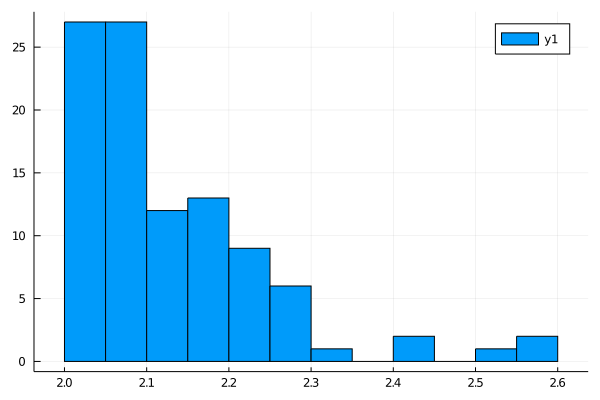

In [380]:
println("Mean of ν: ", mean(data_λ[:, 2]))
println("Variance of ν: ", var(data_λ[:, 2]))
histogram(data_λ[:, 2])

# Question 3

Consider the Bayesian linear regression model. The likelihood is $y_1, y_2, \cdots, y_n \hspace{4pt} \vert \hspace{4pt} \beta, \sigma^2 \sim N_n(X\beta, \sigma^2 I_n)$ just like regular MLE. We assume priors: $\beta \sim N_p(\mu, \sigma^2 I_p)$ and $\sigma^2 \sim \textit{Inverse Gamma }(a, b)$.
$N_p$ is the p-dimensional multivariate normal distribution and density of $\textit{Inverse Gamma}(a, b)$ is given as:
$$
\pi(\sigma^2) \propto e^{-b/\sigma^2} \left(\frac{1}{\sigma^2}\right)^{-a+1}
$$
Here $a$, $b$ and $\mu$ are hyper-parameters, which need to be chosen according to the dataset.
- What is the posterior distribution of $(\beta, \sigma^2)$
- Implement an MH algorithm to sample from the posterior distribution for any suitable dataset

## Solution

> Posterior belief $\propto$ Evidence * Prior belief
  
Let $\lambda$ be the model parameters, i.e. $\beta$ being weights $(p \times 1)$ for regression, $\sigma^2$ introducing variance to frequentist approach.  
$P(\lambda \vert Y) = \frac{P(Y \vert \lambda) P (\lambda)}{P(Y)}$. This can be interpreted as getting the distribution of $\lambda$ after observing $Y$ being sampled from the prior distribution which $\lambda$ had.

Posterior distribution $P(\lambda \vert Y)$
$$
\propto P(Y \vert (\beta, \sigma^2)) P(\beta \vert \sigma^2) P(\sigma^2) \\
\propto N_n(X\beta, \sigma^2 I_n) * N_p(\mu, \sigma^2 I_p) * e^{-b/\sigma^2} \left(\frac{1}{\sigma^2}\right)^{-a+1} \\
\propto e^{-\frac{1}{2}(x-X\beta)^T\Sigma(x-X\beta)} * e^{-\frac{1}{2}(\beta-\mu)^T\Sigma(\beta-\mu)} * e^{-b/\sigma^2} \left(\frac{1}{\sigma^2}\right)^{-a+1} \\
\propto e^{-\frac{1}{2}(x-X\beta)^T \sigma^2 I_n (x-X\beta) - \frac{1}{2}(\beta-\mu)^T \sigma^2 I_p (\beta-\mu) - \frac{b}{\sigma^2}} \left(\frac{1}{\sigma^2}\right)^{-a+1}
$$

In [381]:
using CSV
using DataFrames
using Plots

In [382]:
df = DataFrame(CSV.File("./housing.csv"))
X = df[:, 1:end-1];
y = df[:, end];
m, p = size(X)

(506, 13)

In [383]:
a = 1;
b = 1.5;
μ = randn(13);

In [384]:
function posterior_pdf(x, λ)
    #=
    λ : tuple containing β and σ^2
    =#
    β = λ[1]
    σ_sq = λ[2]
    n = -0.5*σ_sq*transpose(x-X*β)*(x-X*β)
    p = -0.5*σ_sq*transpose(β-μ)*(β-μ)
    g = -b/σ_sq
    r1 = exp(n+p+g)
    r2 = (1/σ_sq)^(-a+1)
    return r1*r2
end

posterior_pdf (generic function with 1 method)

In [385]:
function proposal_pdf(x_new, x_curr)
    #=
    Proposal distribution that has the same support as posterior
    p-dim Normal distribution
    =#
    return exp(-transpose(x_new - x_curr)*(x_new - x_curr)/2)
end

proposal_pdf (generic function with 1 method)